In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 18})


# data summary

In [67]:
comment_data = pd.read_csv('../data/train.csv.zip', 
                           header=0, 
                           compression='zip')

In [70]:
comment_data.loc[:,'toxic':'identity_hate']

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


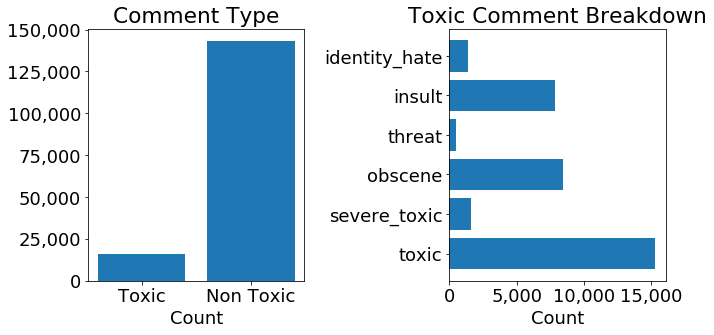

In [69]:
fig, ax = plt.subplots(1,2)

#c = np.sum(comment_data.loc[:,'toxic':'identity_hate'].any(axis=1))
counts = {
    'Toxic' : 16225,
    'Non Toxic' : 143346
}

ax[0].bar(counts.keys(), counts.values())
ax[0].set_yticklabels(['{:,}'.format(int(x)) for x in ax[0].get_yticks().tolist()])
ax[0].set_xlabel("Count")
ax[0].set_title("Comment Type")


tox_counts = comment_data.loc[:,'toxic':'identity_hate'].sum().to_dict()

ax[1].barh(list(tox_counts.keys()), tox_counts.values())
ax[1].set_xticklabels(['{:,}'.format(int(x)) for x in ax[1].get_xticks().tolist()])
ax[1].set_xlabel("Count")
ax[1].set_title("Toxic Comment Breakdown")

fig.tight_layout()

## word counts

In [71]:
word_counts = pd.read_csv('../word_lists/all_words_ascii_noquote_nodigit_destem.tsv', sep='\t', header=None)
word_counts.columns = ['word', 'counts']

In [72]:
word_counts

,word,counts
0,shirvington,1
1,aircracft,1
2,yvesnimmo,1
3,voydan,1
4,mitsurugi,1
...,...,...
142270,you,218200
142271,and,224236
142272,of,225062
142273,to,297516


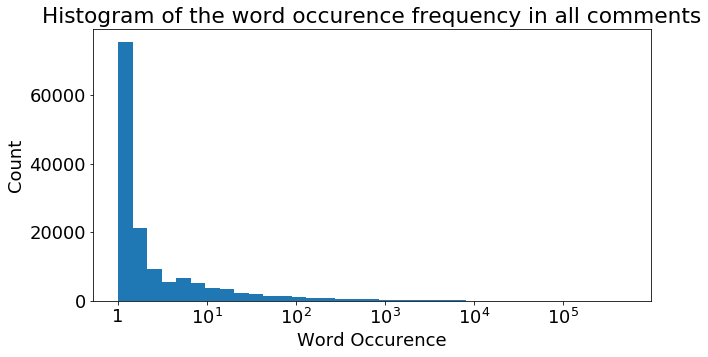

In [75]:
fig, ax = plt.subplots()
plt.hist(np.log10(word_counts.counts), bins=35)
plt.title('Histogram of the word occurence frequency in all comments')
plt.xlabel('Word Occurence')
plt.ylabel('Count')
ax.set_xticklabels(['','1','$10^1$','$10^2$','$10^3$','$10^4$','$10^5$']);
#ax.set_yscale('log')